In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy
import pickle

#### Read in Data

In [5]:
df = pd.read_csv('../Downloads/MSFT Fundamentals Quarterly.csv', 
                 delimiter = ',', 
                 parse_dates = True, 
                 index_col = 'Unnamed: 0')

##Alternative method
#path = input()
#df = pd.read_csv(path)

#### Find Categorical and Numeric Columns

In [6]:
df['Net Sales ($mil)'][0].dtype
cat_cols = [cname for cname in df.columns if df[cname].dtype not in ['int64','float64']]
len(cat_cols)
cat_cols

['Ticker']

In [7]:
int_cols = [cname for cname in df.columns if df[cname].dtype == 'int64']

#### Explore Missing Values

In [8]:
df.dropna(axis = 0, subset= ['Net Sales ($mil)'], inplace=True)

#series_null = df.isnull().sum().sort_values(ascending = False).head(50)
df_null = pd.DataFrame([df.columns, df.isnull().sum()], index = ['Feature', 'Null Count']).T
df_null.sort_values(by= 'Null Count', ascending = False, inplace = True)
df_null_top = df_null.head(50).copy()
df_null_top
#preprocessor = SimpleImputer(strategy='mean')

,Feature,Null Count
100,Extraordinary Items ($mil),120
113,R-Discontinued Operations ($mil),120
112,R-Extraordinary Items ($mil),120
5,Discontinued Operations ($mil),120
10,Preferred Dividends Accrued ($mil),108
124,R-Property/Plant/Equipment ($mil),87
22,Property/Plant/Equipment ($mil),84
24,Accumulated Depreciation ($mil),84
16,Raw Materials ($mil),72
17,Work in Process ($mil),72


#### Shift Dependent Variable for Prediction

In [9]:
df['Net Sales FY1'] = df['Net Sales ($mil)'].shift(1)

#### Visualize and Analyze Dependent Variable

count      119.000000
mean     12211.068337
std       9527.377327
min        369.399994
25%       3679.500000
50%      10161.000000
75%      19924.500000
max      36906.000000
Name: Net Sales FY1, dtype: float64


Text(0, 0.5, '(Log) Net Sales ($mil)')

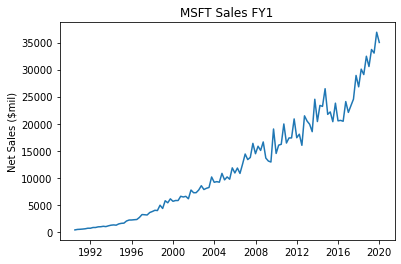

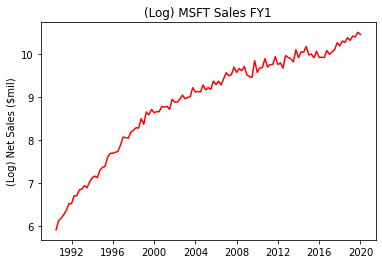

In [10]:
print(df['Net Sales FY1'][1:].describe())
plt.subplots(1,1)
plt.plot(df['Net Sales FY1'][1:])
plt.title('MSFT Sales FY1')
plt.ylabel('Net Sales ($mil)')
plt.subplots(1,1)
plt.plot(np.log(df['Net Sales FY1'][1:]), color = 'r')
plt.title('(Log) MSFT Sales FY1')
plt.ylabel('(Log) Net Sales ($mil)')

#### Split Data into X and y

In [180]:
y = df['Net Sales FY1']
X = df.copy()

#### Drop Specified Columns

In [181]:
#Drop columns with more than 50% NA's
drop_cols = [cname for cname in X.columns if ((X[cname].isnull().sum()/len(X)) > 0.50) or ()]
drop_cols.append('Net Sales FY1')
drop_cols.append('Ticker')
drop_cols.append('SEC Date (yyyymmdd)')
drop_cols.append('EPS Report Date (yyyymmdd)')
X.drop(drop_cols, axis = 1, inplace=True)

#### Drop Columns with all Zeroes (optional)

In [182]:
zero_cols = [cname for cname in X.columns if (X[cname].sum() == 0) & (X[cname].mean() == 0.)]

#X.drop(zero_cols, axis = 1, inplace=True)

zero_cols

['Notes Receivable ($mil)',
 'Current Capital Leases ($mil)',
 'Mortgages ($mil)',
 'Convertible Debt ($mil)',
 'Treasury Stock ($mil)',
 'Minority Interest ($mil).1',
 'Investment Gain/Loss ($mil)',
 'Other Income ($mil)']

#### Visualize Correlations

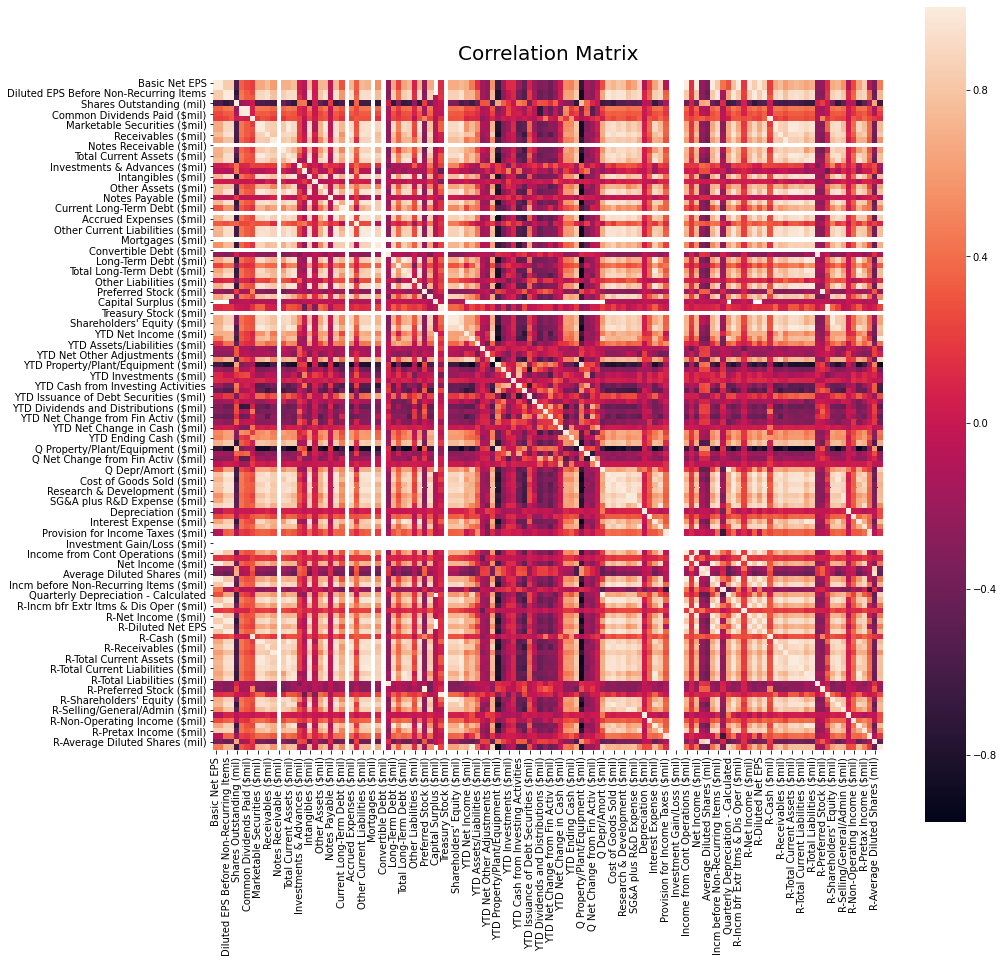

In [65]:
corr_mat = X.iloc[:,:].corr()

plt.figure(figsize=(15,15))
plt.title('Correlation Matrix', size = 20, pad = 20)
sb.heatmap(corr_mat, vmax = 1., square = True)

plt.show()

#### Subsections of Corr Matrix

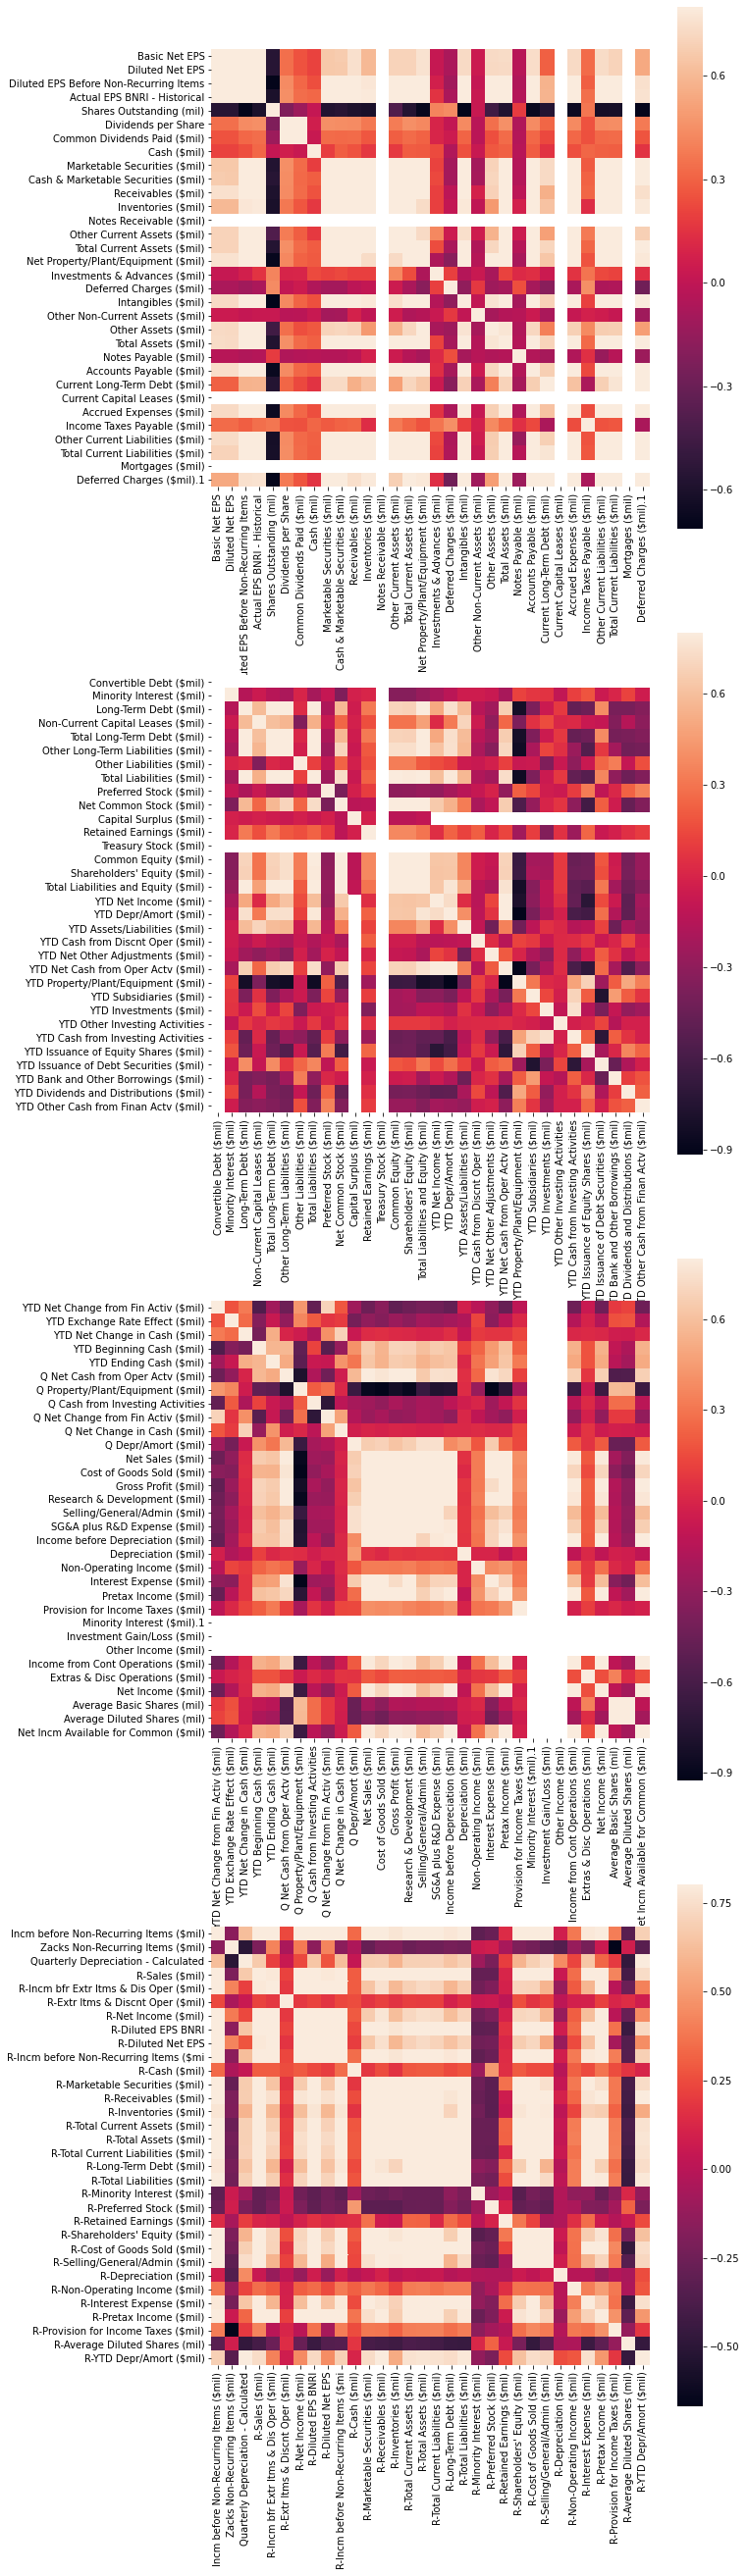

In [66]:
split_X = int((X.shape[1]/4))

X_1 = X.iloc[:,0:split_X].copy()
X_2 = X.iloc[:,split_X:split_X*2].copy()
X_3 = X.iloc[:,split_X*2:split_X*3].copy()
X_4 = X.iloc[:,split_X*3:].copy()


corr_mat_1 = X_1.corr()
corr_mat_2 = X_2.corr()
corr_mat_3 = X_3.corr()
corr_mat_4 = X_4.corr()

fig, axs = plt.subplots(nrows = 4, ncols = 1, figsize = (10,45))

sb.heatmap(corr_mat_1, vmax = .8, square = True, ax=axs[0])
sb.heatmap(corr_mat_2, vmax = .8, square = True, ax=axs[1])
sb.heatmap(corr_mat_3, vmax = .8, square = True, ax=axs[2])
sb.heatmap(corr_mat_4, vmax = .8, square = True, ax=axs[3])

#### Split Data into Train, Valid, and Test

In [183]:
train_idx = int(len(X)*0.375)
train_size = int(len(X)*0.625)
print('Train Size: {}'.format(train_size))

valid_idx = int(len(X)*0.125)
valid_size = int(len(X)*0.25)
print('Valid Size: {}'.format(valid_size))

test_idx = int(len(X)*0.125)
test_size = int(len(X)*0.125)
print('Test Size: {}'.format(test_size))

print('Data Size: {}'.format(len(X)))

X_train = X.iloc[train_idx:,:].copy()
y_train = y.iloc[train_idx:].copy()
X_valid = X.iloc[valid_idx:train_idx,:].copy()
y_valid = y.iloc[valid_idx:train_idx].copy()
X_test = X.iloc[0:test_idx,:].copy()
y_test = y.iloc[0:test_idx].copy()

#Combined train and valid data for final model training
X_cmbn = X.iloc[valid_size:,:].copy()
y_cmbn = y.iloc[valid_size:].copy()

Train Size: 75
Valid Size: 30
Test Size: 15
Data Size: 120


#### Basic Preprocessing

In [184]:
#Fill remaining columns with previous value and then future value if needed
print(X_train.isnull().sum().sort_values(ascending = False).head())
X_train.fillna(method = 'bfill', inplace = True)
X_train.fillna(method = 'ffill', inplace = True)
print(X_train.isnull().sum().sort_values(ascending = False).head())

print(X_valid.isnull().sum().sort_values(ascending = False).head())
X_valid.fillna(method = 'bfill', inplace = True)
X_valid.fillna(method = 'ffill', inplace = True)
print(X_valid.isnull().sum().sort_values(ascending = False).head())

print(X_test.isnull().sum().sort_values(ascending = False).head())
X_test.fillna(method = 'bfill', inplace = True)
X_test.fillna(method = 'ffill', inplace = True)
print(X_test.isnull().sum().sort_values(ascending = False).head())

Q Depr/Amort ($mil)                   22
Q Net Change in Cash ($mil)           22
Q Net Change from Fin Activ ($mil)    22
Q Cash from Investing Activities      22
Q Property/Plant/Equipment ($mil)     22
dtype: int64
R-YTD Depr/Amort ($mil)              0
R-Average Diluted Shares (mil)       0
Minority Interest ($mil)             0
Long-Term Debt ($mil)                0
Non-Current Capital Leases ($mil)    0
dtype: int64
R-YTD Depr/Amort ($mil)              0
R-Average Diluted Shares (mil)       0
Minority Interest ($mil)             0
Long-Term Debt ($mil)                0
Non-Current Capital Leases ($mil)    0
dtype: int64
R-YTD Depr/Amort ($mil)              0
R-Average Diluted Shares (mil)       0
Minority Interest ($mil)             0
Long-Term Debt ($mil)                0
Non-Current Capital Leases ($mil)    0
dtype: int64
R-YTD Depr/Amort ($mil)              0
R-Average Diluted Shares (mil)       0
Minority Interest ($mil)             0
Long-Term Debt ($mil)                0
No

#### Add Bias Columns

In [185]:
X_train_no_bias = X_train.copy()
X_valid_no_bias = X_valid.copy()
X_test_no_bias = X_test.copy()

X_train['Bias'] = 1
X_valid['Bias'] = 1
X_test['Bias'] = 1

#### Pickle Data for API Use

In [ ]:
file_X_train = open('X_train.pickle','wb')
pickle.dump(X_train, file_X_train)
file_X_train.close()

file_X_valid = open('X_valid.pickle','wb')
pickle.dump(X_valid, file_X_valid)
file_X_valid.close()

file_X_test = open('X_test.pickle','wb')
pickle.dump(X_test, file_X_test)
file_X_test.close()

In [205]:
file_X_test_nb = open('X_test_nb.pickle','wb')
pickle.dump(X_test_no_bias, file_X_test_nb)
file_X_test_nb.close()

#### Function to Print Metrics

In [69]:
def get_scores(model):
    predictions = model.predict(X_valid)
    return ('Training Score', model.score(X_train,y_train), 'Validation Score', model.score(X_valid,y_valid), 
            'MAE', mean_absolute_error(predictions,y_valid), 'MSE', mean_squared_error(predictions, y_valid))

#### Print R squared for NN's

In [202]:
def get_r2(model, is_NN = False, x = X_valid, y_true = y_valid):
    if is_NN:
        y_preds = (model.predict(x, batch_size=32)).flatten()
    else:
        y_preds = model.predict(x)
        
    numerator = ((y_true - y_preds) ** 2).sum(axis=0)
    denominator = ((y_true - np.average(y_true, axis=0)) ** 2).sum(axis=0)
    
    return ('R squared: {}'.format(numerator/denominator))

#### Create Random Forest and Fit Model

In [73]:
#Should use gridsearch
rf_model = RandomForestRegressor(n_estimators = 500, 
                              min_samples_leaf= 1, 
                              max_features='sqrt', 
                              criterion = 'mae', 
                              random_state= 0,
                              oob_score= True)

rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_valid)
for i in range(valid_size):
    print('Prediction: {}, Actual: {}'.format(preds[i], y_valid[i]))
print('MAE: {}'.format(mean_absolute_error(y_valid, preds)))
print('MSE: {}'.format(mean_squared_error(y_valid, preds)))
print('OOB: {}'.format(rf_model.oob_score_))

print(get_scores(rf_model))
print(get_r2(rf_model))


#pipe = Pipeline(steps= [('preprocessor', preprocessor), ('model', model)])

Prediction: 13183.724, Actual: 20453.0
Prediction: 13151.18, Actual: 20614.0
Prediction: 13406.878, Actual: 20531.0
Prediction: 13407.704, Actual: 23796.0
Prediction: 12691.946, Actual: 20379.0
Prediction: 13425.28, Actual: 22180.0
Prediction: 13392.448, Actual: 21729.0
Prediction: 13438.118, Actual: 26470.0
Prediction: 13408.08, Actual: 23201.0
Prediction: 13411.81, Actual: 23382.0
Prediction: 13436.434, Actual: 20403.0
Prediction: 13362.154, Actual: 24519.0
Prediction: 13443.372, Actual: 18529.0
Prediction: 13406.768, Actual: 19896.0
Prediction: 13452.536, Actual: 20489.0
Prediction: 13523.926, Actual: 21456.0
Prediction: 12847.7178000488, Actual: 16008.0
Prediction: 13468.864, Actual: 18059.0
Prediction: 13594.352, Actual: 17407.0
Prediction: 13601.242, Actual: 20885.0
Prediction: 13447.126, Actual: 17372.0
Prediction: 13296.704, Actual: 17367.0
Prediction: 13530.184, Actual: 16428.0
Prediction: 13816.076, Actual: 19953.0
Prediction: 13725.9, Actual: 16195.0
Prediction: 13778.67, Ac

#### Feature Importance

In [74]:
feat_imp = pd.DataFrame([X.columns, rf_model.feature_importances_], index = ['Feature', 'Importance']).T
feat_imp.sort_values(by=['Importance'], ascending = False, inplace = True)
feat_imp.head(35)

,Feature,Importance
41,Net Common Stock ($mil),0.0431203
39,Total Liabilities ($mil),0.039513
47,Total Liabilities and Equity ($mil),0.0360593
29,Total Current Liabilities ($mil),0.0349378
114,R-Total Liabilities ($mil),0.031936
99,R-Sales ($mil),0.0311532
14,Total Current Assets ($mil),0.0297304
111,R-Total Assets ($mil),0.0292719
15,Net Property/Plant/Equipment ($mil),0.0281233
21,Total Assets ($mil),0.0276724


#### Inspect Important Features

<Figure size 1800x1440 with 0 Axes>

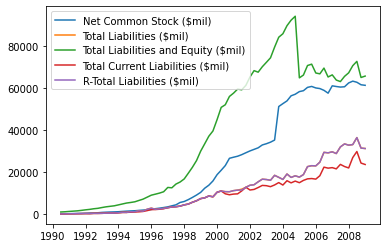

<Figure size 1800x1440 with 0 Axes>

In [98]:
top_i_feats = list(feat_imp.Feature[0:5])
[plt.plot(X_train.index, X_train[feat_i]) for feat_i in top_i_feats]
plt.legend(top_i_feats, loc = 0)
plt.figure(figsize=(25,20))

In [99]:
X_train[top_i_feats].describe()

,Net Common Stock ($mil),Total Liabilities ($mil),Total Liabilities and Equity ($mil),Total Current Liabilities ($mil),R-Total Liabilities ($mil)
count,75.000000,75.000000,75.000000,75.000000,75.000000
mean,24889.329559,11528.697120,39084.212479,9391.217120,11523.004520
std,24545.301107,10958.880484,30977.556506,8262.010351,10958.759339
min,219.520004,186.785996,1105.348999,186.785996,186.785996
25%,1780.500000,1346.500000,6276.500000,1140.500000,1346.500000
50%,15878.000000,8718.000000,39672.000000,8718.000000,8718.000000
75%,55185.500000,18015.500000,66612.500000,15071.500000,18015.500000
max,63375.000000,36507.000000,94268.000000,29886.000000,36507.000000


#### Plot Feature Importance Curve

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

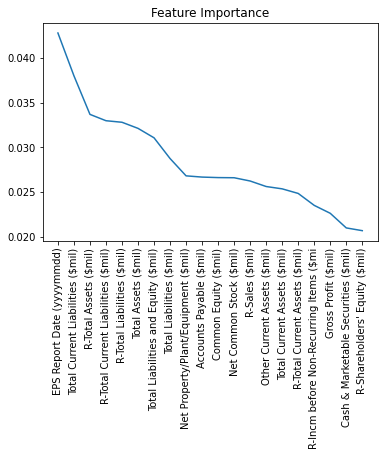

In [24]:
plt.plot(feat_imp['Feature'][0:20], feat_imp['Importance'][0:20])
plt.title('Feature Importance')
plt.xticks(rotation='vertical')

##### Why are many of the top features related to the Balance Sheet?

#### Check if top features had signifcant number of null values

In [25]:
top_features = list(feat_imp['Feature'][0:20]).copy()
print(top_features)
null_top_feats = [feat for feat in top_features if (feat in list(df_null_top['Feature']))]
null_top_feats

['EPS Report Date (yyyymmdd)', 'Total Current Liabilities ($mil)', 'R-Total Assets ($mil)', 'R-Total Current Liabilities ($mil)', 'R-Total Liabilities ($mil)', 'Total Assets ($mil)', 'Total Liabilities and Equity ($mil)', 'Total Liabilities ($mil)', 'Net Property/Plant/Equipment ($mil)', 'Accounts Payable ($mil)', 'Common Equity ($mil)', 'Net Common Stock ($mil)', 'R-Sales ($mil)', 'Other Current Assets ($mil)', 'Total Current Assets ($mil)', 'R-Total Current Assets ($mil)', 'R-Incm before Non-Recurring Items ($mi', 'Gross Profit ($mil)', 'Cash & Marketable Securities ($mil)', "R-Shareholders' Equity ($mil)"]


[]

In [27]:
if len(null_top_feats) > 0:
    df_null_top[df_null_top['Feature'] == null_top_feats[0]]
else: pass

#### Redundant Feature Analysis

In [28]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(X).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X.columns, orientation='right', leaf_font_size=16)
plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (

ValueError: Distance matrix 'X' must be symmetric.

#### SVR with Linear Kernel (FIX)

In [29]:
svr_model = SVR(kernel='rbf', C = 1, gamma='auto')

#pipe = Pipeline(steps= [('preprocessor', preprocessor), ('model', model)])
svr_model.fit(X_train, y_train)
preds = svr_model.predict(X_valid)
for i in range(valid_size):
    print('Prediction: {}, Actual: {}'.format(preds[i], y_valid[i]))
print('MAE: {}'.format(mean_absolute_error(y_valid, preds)))
print('MSE: {}'.format(mean_squared_error(y_valid, preds)))

print(get_scores(svr_model))
print(get_r2(svr_model))

Prediction: 5764.0, Actual: 20453.0
Prediction: 5764.0, Actual: 20614.0
Prediction: 5764.0, Actual: 20531.0
Prediction: 5764.0, Actual: 23796.0
Prediction: 5764.0, Actual: 20379.0
Prediction: 5764.0, Actual: 22180.0
Prediction: 5764.0, Actual: 21729.0
Prediction: 5764.0, Actual: 26470.0
Prediction: 5764.0, Actual: 23201.0
Prediction: 5764.0, Actual: 23382.0
Prediction: 5764.0, Actual: 20403.0
Prediction: 5764.0, Actual: 24519.0
Prediction: 5764.0, Actual: 18529.0
Prediction: 5764.0, Actual: 19896.0
Prediction: 5764.0, Actual: 20489.0
Prediction: 5764.0, Actual: 21456.0
Prediction: 5764.0, Actual: 16008.0
Prediction: 5764.0, Actual: 18059.0
Prediction: 5764.0, Actual: 17407.0
Prediction: 5764.0, Actual: 20885.0
Prediction: 5764.0, Actual: 17372.0
Prediction: 5764.0, Actual: 17367.0
Prediction: 5764.0, Actual: 16428.0
Prediction: 5764.0, Actual: 19953.0
Prediction: 5764.0, Actual: 16195.0
Prediction: 5764.0, Actual: 16039.0
Prediction: 5764.0, Actual: 14503.0
Prediction: 5764.0, Actual: 

#### XGBoost Model

In [30]:
xgb_model = XGBRegressor(n_estimators = 500, objective='reg:squarederror', reg_lambda=0.5,booster='gbtree',random_state= 0)

#pipe = Pipeline(steps= [('preprocessor', preprocessor), ('model', model)])
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_valid)
for i in range(valid_size):
    print('Prediction: {}, Actual: {}'.format(preds[i], y_valid[i]))
print('MAE: {}'.format(mean_absolute_error(y_valid, preds)))
print('MSE: {}'.format(mean_squared_error(y_valid, preds)))

print(get_scores(xgb_model))
print(get_r2(xgb_model))

Prediction: 14798.2001953125, Actual: 20453.0
Prediction: 14885.2099609375, Actual: 20614.0
Prediction: 15643.6376953125, Actual: 20531.0
Prediction: 15644.7939453125, Actual: 23796.0
Prediction: 13953.7880859375, Actual: 20379.0
Prediction: 15641.3095703125, Actual: 22180.0
Prediction: 15645.7880859375, Actual: 21729.0
Prediction: 15650.7802734375, Actual: 26470.0
Prediction: 15410.564453125, Actual: 23201.0
Prediction: 15600.8779296875, Actual: 23382.0
Prediction: 15643.7666015625, Actual: 20403.0
Prediction: 15597.0087890625, Actual: 24519.0
Prediction: 15372.90234375, Actual: 18529.0
Prediction: 15593.041015625, Actual: 19896.0
Prediction: 15646.1181640625, Actual: 20489.0
Prediction: 15876.4833984375, Actual: 21456.0
Prediction: 13917.4140625, Actual: 16008.0
Prediction: 15598.2197265625, Actual: 18059.0
Prediction: 15634.4072265625, Actual: 17407.0
Prediction: 15875.7568359375, Actual: 20885.0
Prediction: 15377.6484375, Actual: 17372.0
Prediction: 15779.5185546875, Actual: 17367.

#### Examing Sales Relationship (1 year lag term)

Pearson: (0.9802724438983977, 3.13055006203297e-84)
Spearman: SpearmanrResult(correlation=0.9852157812277456, pvalue=1.691353292264144e-91)


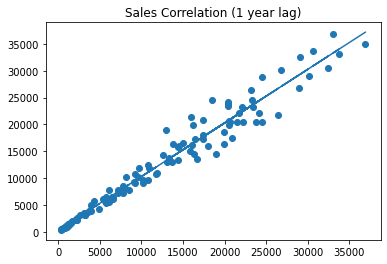

In [31]:
plt.title('Sales Correlation (1 year lag)')
plt.scatter(X['Net Sales ($mil)'][1:], y[1:])

m,b = np.polyfit(X['Net Sales ($mil)'][1:], y[1:], deg=1)
x = X['Net Sales ($mil)'][1:].copy()
plt.plot(X['Net Sales ($mil)'][1:], m*x + b)

from scipy.stats import pearsonr, spearmanr

print('Pearson: {}'.format(pearsonr(X['Net Sales ($mil)'][1:], y[1:])))
print('Spearman: {}'.format(spearmanr(X['Net Sales ($mil)'][1:], y[1:])))

#### So, why doesn't previous sales show up as an important feature?

#### Neural Network

In [126]:
_NN_model = Sequential()

#Input Layer
_NN_model.add(Dense(128, activation='relu', kernel_initializer='normal', input_dim = X_train.shape[1]))

#Hidden Layer
_NN_model.add(Dense(256, activation='relu', kernel_initializer='normal'))

#Output Layer
_NN_model.add(Dense(1, activation='linear', kernel_initializer='normal'))

#Compile Model
_NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
_NN_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               16640     
_________________________________________________________________
dense_18 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 257       
Total params: 49,921
Trainable params: 49,921
Non-trainable params: 0
_________________________________________________________________


In [127]:
checkpoint_name = 'Weights-{epoch:05d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [128]:
_NN_model.fit(X_train, y_train, batch_size=32, validation_data=(X_valid, y_valid), shuffle=False, epochs=100, callbacks=callbacks_list)


Train on 75 samples, validate on 30 samples
Epoch 1/100
75/75 [==============================] - 0s 3ms/step - loss: 5826.8883 - mean_absolute_error: 5826.8882 - val_loss: 4917.6548 - val_mean_absolute_error: 4917.6548

Epoch 00001: val_loss improved from inf to 4917.65479, saving model to Weights-00001--4917.65479.hdf5
Epoch 2/100
75/75 [==============================] - 0s 143us/step - loss: 1547.4765 - mean_absolute_error: 1547.4764 - val_loss: 2631.5759 - val_mean_absolute_error: 2631.5759

Epoch 00002: val_loss improved from 4917.65479 to 2631.57593, saving model to Weights-00002--2631.57593.hdf5
Epoch 3/100
75/75 [==============================] - 0s 155us/step - loss: 1499.8688 - mean_absolute_error: 1499.8689 - val_loss: 2623.1313 - val_mean_absolute_error: 2623.1313

Epoch 00003: val_loss improved from 2631.57593 to 2623.13135, saving model to Weights-00003--2623.13135.hdf5
Epoch 4/100
75/75 [==============================] - 0s 199us/step - loss: 971.5299 - mean_absolute_erro

75/75 [==============================] - 0s 105us/step - loss: 256.2918 - mean_absolute_error: 256.2917 - val_loss: 2731.7439 - val_mean_absolute_error: 2731.7439

Epoch 00035: val_loss did not improve from 2397.14673
Epoch 36/100
75/75 [==============================] - 0s 106us/step - loss: 361.6291 - mean_absolute_error: 361.6291 - val_loss: 2813.5581 - val_mean_absolute_error: 2813.5581

Epoch 00036: val_loss did not improve from 2397.14673
Epoch 37/100
75/75 [==============================] - 0s 149us/step - loss: 365.3945 - mean_absolute_error: 365.3945 - val_loss: 2755.2383 - val_mean_absolute_error: 2755.2383

Epoch 00037: val_loss did not improve from 2397.14673
Epoch 38/100
75/75 [==============================] - 0s 114us/step - loss: 402.3922 - mean_absolute_error: 402.3922 - val_loss: 2781.0667 - val_mean_absolute_error: 2781.0667

Epoch 00038: val_loss did not improve from 2397.14673
Epoch 39/100
75/75 [==============================] - 0s 121us/step - loss: 367.2082 - me


Epoch 00070: val_loss did not improve from 2397.14673
Epoch 71/100
75/75 [==============================] - 0s 148us/step - loss: 373.5695 - mean_absolute_error: 373.5695 - val_loss: 2626.7605 - val_mean_absolute_error: 2626.7605

Epoch 00071: val_loss did not improve from 2397.14673
Epoch 72/100
75/75 [==============================] - 0s 101us/step - loss: 438.9356 - mean_absolute_error: 438.9356 - val_loss: 2866.6892 - val_mean_absolute_error: 2866.6892

Epoch 00072: val_loss did not improve from 2397.14673
Epoch 73/100
75/75 [==============================] - 0s 125us/step - loss: 352.8333 - mean_absolute_error: 352.8333 - val_loss: 2494.6086 - val_mean_absolute_error: 2494.6086

Epoch 00073: val_loss did not improve from 2397.14673
Epoch 74/100
75/75 [==============================] - 0s 103us/step - loss: 267.6031 - mean_absolute_error: 267.6031 - val_loss: 2627.8984 - val_mean_absolute_error: 2627.8984

Epoch 00074: val_loss did not improve from 2397.14673
Epoch 75/100
75/75 [=

In [134]:
#Load weights file of the best model
_weights_file = 'Weights-00006--2397.14673.hdf5' # choose the best checkpoint 
_NN_model.load_weights(_weights_file) # load it
_NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])


In [135]:
print(get_r2(_NN_model, is_NN = True))

R squared: 0.9468076458517585


#### Neural Network #2 (with Additional Hidden Layers)

In [195]:
NN_model = Sequential()

#Input Layer
NN_model.add(Dense(128, activation='relu', kernel_initializer='normal', input_dim = X_train_no_bias.shape[1]))

#Hidden Layer
NN_model.add(Dense(256, activation='relu', kernel_initializer='normal'))
NN_model.add(Dense(256, activation='relu', kernel_initializer='normal'))
NN_model.add(Dense(256, activation='relu', kernel_initializer='normal'))

#Output Layer
NN_model.add(Dense(1, activation='linear', kernel_initializer='normal'))

#Compile Model
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_36 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_37 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_38 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 257       
Total params: 181,377
Trainable params: 181,377
Non-trainable params: 0
_________________________________________________________________


In [196]:
checkpoint_name = 'Weights2-{epoch:05d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [197]:
NN_model.fit(X_train_no_bias, y_train, batch_size=32, validation_data=(X_valid_no_bias, y_valid), shuffle=False, epochs=100, callbacks=callbacks_list)

Train on 75 samples, validate on 30 samples
Epoch 1/100
75/75 [==============================] - 0s 6ms/step - loss: 5657.0742 - mean_absolute_error: 5657.0742 - val_loss: 4581.3179 - val_mean_absolute_error: 4581.3179

Epoch 00001: val_loss improved from inf to 4581.31787, saving model to Weights2-00001--4581.31787.hdf5
Epoch 2/100
75/75 [==============================] - 0s 165us/step - loss: 1514.9519 - mean_absolute_error: 1514.9520 - val_loss: 7413.1094 - val_mean_absolute_error: 7413.1094

Epoch 00002: val_loss did not improve from 4581.31787
Epoch 3/100
75/75 [==============================] - 0s 241us/step - loss: 2563.4158 - mean_absolute_error: 2563.4158 - val_loss: 4022.5786 - val_mean_absolute_error: 4022.5786

Epoch 00003: val_loss improved from 4581.31787 to 4022.57861, saving model to Weights2-00003--4022.57861.hdf5
Epoch 4/100
75/75 [==============================] - 0s 151us/step - loss: 1343.9287 - mean_absolute_error: 1343.9286 - val_loss: 7289.3179 - val_mean_absolu

75/75 [==============================] - 0s 173us/step - loss: 295.1942 - mean_absolute_error: 295.1942 - val_loss: 2440.2981 - val_mean_absolute_error: 2440.2981

Epoch 00034: val_loss did not improve from 2388.64990
Epoch 35/100
75/75 [==============================] - 0s 223us/step - loss: 308.4471 - mean_absolute_error: 308.4471 - val_loss: 2853.0120 - val_mean_absolute_error: 2853.0120

Epoch 00035: val_loss did not improve from 2388.64990
Epoch 36/100
75/75 [==============================] - 0s 246us/step - loss: 331.1446 - mean_absolute_error: 331.1446 - val_loss: 2670.3750 - val_mean_absolute_error: 2670.3750

Epoch 00036: val_loss did not improve from 2388.64990
Epoch 37/100
75/75 [==============================] - 0s 193us/step - loss: 589.5672 - mean_absolute_error: 589.5672 - val_loss: 3179.9719 - val_mean_absolute_error: 3179.9719

Epoch 00037: val_loss did not improve from 2388.64990
Epoch 38/100
75/75 [==============================] - 0s 209us/step - loss: 480.3289 - me


Epoch 00069: val_loss did not improve from 2388.64990
Epoch 70/100
75/75 [==============================] - 0s 241us/step - loss: 311.9923 - mean_absolute_error: 311.9923 - val_loss: 2717.6160 - val_mean_absolute_error: 2717.6160

Epoch 00070: val_loss did not improve from 2388.64990
Epoch 71/100
75/75 [==============================] - 0s 190us/step - loss: 255.2953 - mean_absolute_error: 255.2953 - val_loss: 2476.4319 - val_mean_absolute_error: 2476.4319

Epoch 00071: val_loss did not improve from 2388.64990
Epoch 72/100
75/75 [==============================] - 0s 177us/step - loss: 247.0660 - mean_absolute_error: 247.0660 - val_loss: 2752.7620 - val_mean_absolute_error: 2752.7620

Epoch 00072: val_loss did not improve from 2388.64990
Epoch 73/100
75/75 [==============================] - 0s 212us/step - loss: 294.2195 - mean_absolute_error: 294.2195 - val_loss: 2476.4541 - val_mean_absolute_error: 2476.4541

Epoch 00073: val_loss did not improve from 2388.64990
Epoch 74/100
75/75 [=

In [198]:
#Load weights file of the best model
#weights_file = 'Weights2-00009--2261.06763.hdf5' # choose the best checkpoint
weights_file = 'Weights2-00025--2388.64990.hdf5' # choose the best checkpoint (no bias)
NN_model.load_weights(weights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [201]:
print(get_r2(NN_model, is_NN = True))

R squared: 0.9147713718417327


#### Save Model for API

In [203]:
file_NN_model = open('NN_model_nb.pickle','wb')
pickle.dump(NN_model, file_NN_model)
file_NN_model.close()
NN_model.save('NN_model_nb_save')

#Serialize model to JSON
NN_model_json = NN_model.to_json()
with open("NN_model_nb.json", "w") as json_file:
    json_file.write(NN_model_json)
# serialize weights to HDF5
NN_model.save_weights("NN_model_nb.h5")

#### Stacked Regression (Meta Model Approach)

In [143]:
a = NN_model.predict(X_test.iloc[0:1,:], batch_size=32)
int(a)

39739

In [179]:
X_train['Bias'] = 1

SyntaxError: invalid syntax (<ipython-input-179-00a5504e8b8d>, line 2)

In [174]:
os.path.abspath('NN_model_save')

'/Users/kevinjoseph/Python/NN_model_saveeee'

In [175]:
from flask import render_template

In [ ]:
render_template()